In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import sys
sys.path.append('..')

from jax import numpy as jnp
import jax
import time
from scipy.integrate import quad, dblquad
import equinox as eqx
import jax_cosmo as jc
from quadax import quadgk, quadcc, quadts, romberg
from functools import partial

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation 
from numpy import loadtxt
from diffrax import Kvaerno5, Tsit5
%matplotlib inline

from plot_params import params
#pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:

from linx.background import BackgroundModel
from linx.nuclear import NuclearRates 
from linx.abundances import AbundanceModel
from linx.reactions import Reaction
from linx.thermo import T_g 
from linx.const import mn, mp, eta0, hbar, me, aFS, NE_pd, NE_min, zeta_3
from scipy.integrate import odeint, solve_ivp, simpson, cumulative_simpson
from linx.pd_rates import decay_model
from linx.injected_spec import InjectedSpectrum, thermal_electron
eps = 1e-3
Emin = 1.5 # MeV
Ephb_T_max = 200

In [5]:
sys.path.append('../../acropolis')
from acropolis.models import DecayModel
from acropolis.nucl import NuclearReactor
from acropolis.params import hbar, me
from acropolis.utils import LogInterp
from scipy.linalg import expm
from acropolis.input import InputInterface, locate_sm_file
from acropolis.cascade import SpectrumGenerator, _PhotonReactionWrapper, _ElectronReactionWrapper, _PositronReactionWrapper, _ReactionWrapperScaffold
from acropolis.params import Emin, Emax_log
from acropolis.db import import_data_from_db
from functools import partial

In [6]:
ii = InputInterface(locate_sm_file())
db = import_data_from_db()
spec = SpectrumGenerator(ii)
photon = _PhotonReactionWrapper(ii, db)
electron = _ElectronReactionWrapper(ii, db)
positron = _PositronReactionWrapper(ii, db)
others = _ReactionWrapperScaffold(ii, db)

INFO   : Extracting and reading database files.
INFO   : Finished after 46.1ms.
INFO   : Extracting and reading database files.
INFO   : Finished after 39.6ms.


In [7]:
Yf = DecayModel(60, 1e5, ii.temperature(1e5), 5e-7, 1, 0)
nr = NuclearReactor(Yf._sS0, Yf._sSc, Yf._sTrg, Yf._sE0, Yf._sII)

INFO   : Extracting and reading database files.
INFO   : Finished after 40.2ms.


In [8]:
bkg_model = BackgroundModel()
t_vec, a_vec, rho_g_vec, rho_nu_vec, rho_NP_vec, p_NP_vec, Neff_vec = bkg_model(jnp.asarray(0.), T_end = 1e-4, max_steps = 512*4)
InjSpec = InjectedSpectrum()
mod = decay_model(60, 1e5, 5e-7, 1, 0, t_vec, a_vec, rho_g_vec)

`\         /´  ||||        ||||  |||||     ||||  ||||   ||||
 /\_______/\   ||||        ||||  |||||||   ||||   |||| ||||
 ) __` ´__ (   ||||        ||||  |||| |||| ||||    |||||||
/  `-|_|-´  \  ||||        ||||  ||||  |||| |||    ||||||| 
/   (_x_)   \  ||||||||||  ||||  ||||   |||||||   |||| ||||
  )  `-´  (    ||||||||||  ||||  ||||    ||||||  ||||   ||||
 
Compiling thermodynamics model...


/home/mkwok/miniconda3/envs/linx/lib/python3.13/site-packages/equinox/_jit.py:55: UserWarning: `diffrax.diffeqsolve(..., discrete_terminating_event=...)` is deprecated in favour of the more general `diffrax.diffeqsolve(..., event=...)` interface. This will be removed in some future version of Diffrax.
  out = fun(*args, **kwargs)


In [9]:
(Tmin, Tmax) = mod.temperature_range()
T_grid = jnp.logspace(jnp.log10(Tmin), jnp.log10(Tmax), 10)
E_grid = jnp.logspace(jnp.log(Emin), jnp.log(30), 200, base=jnp.e)
X_grid = jnp.arange(3)


## Rates and Kernels

In [10]:
g1 = jax.vmap(InjSpec.kernel_x, in_axes=(None, None, None, None, 0))
g2 = jax.vmap(g1, in_axes=(None, None, 0, None, None))
g3 = jax.vmap(g2, in_axes=(None, 0, None, None, None))
g4 = jax.vmap(g3, in_axes=(0, None, None, None, None))

K_linx = jnp.triu(g4(X_grid, X_grid, E_grid, T_grid[4], E_grid))
K_acro = jnp.array([[[[spec._kernel_x_xp(float(X), float(Xp), float(E), float(Ep), float(T_grid[4])) if Ep >= E else 0. for Ep in E_grid] for E in E_grid] for Xp in X_grid] for X in X_grid])

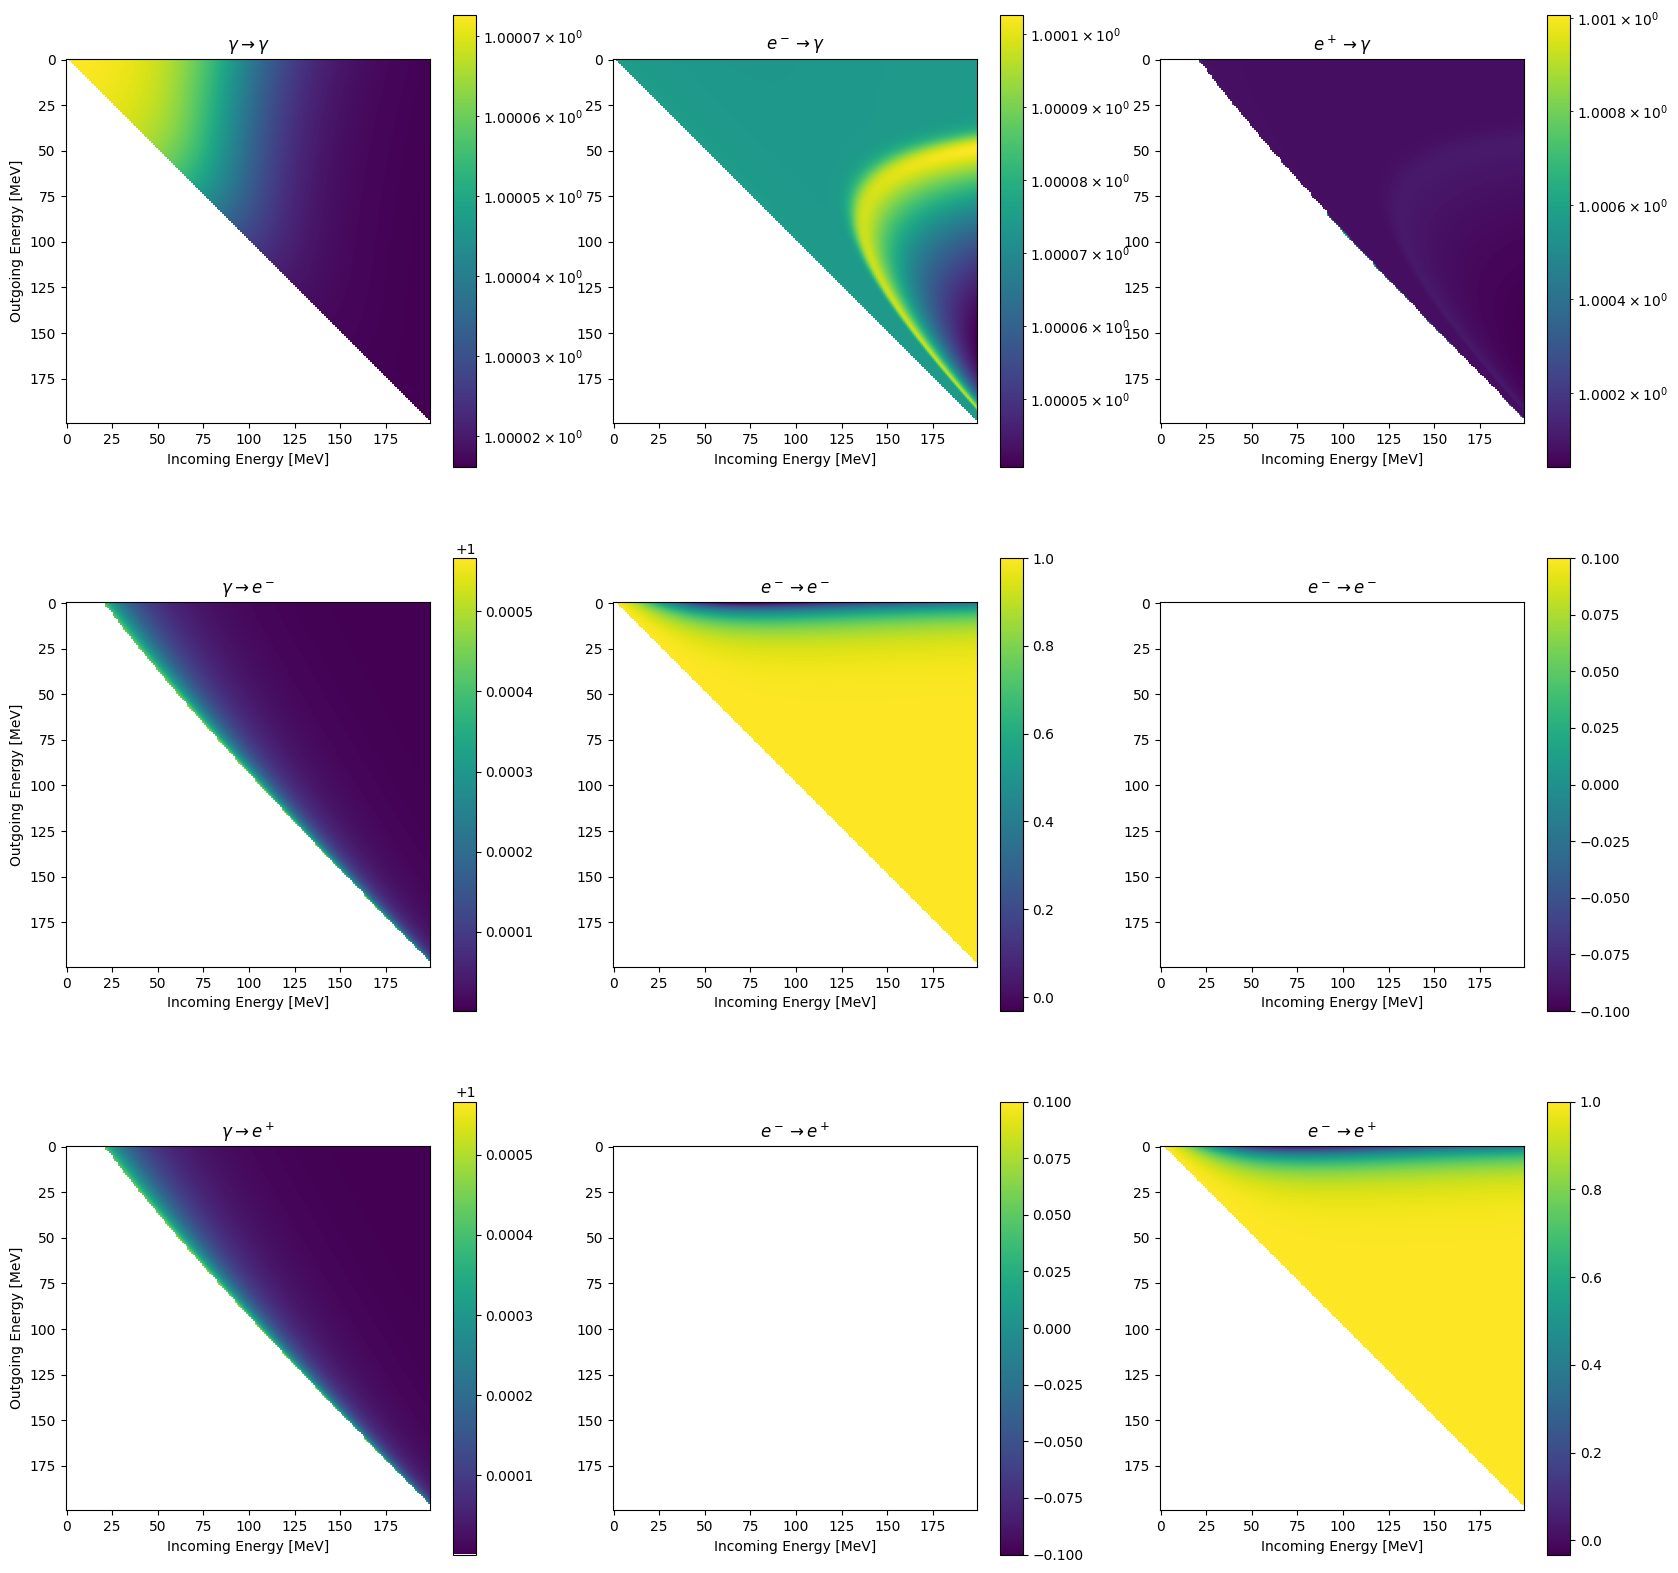

In [11]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 1)
plt.imshow(K_linx[0, 0]/K_acro[0, 0], norm=matplotlib.colors.LogNorm())
plt.title(r'$\gamma  \rightarrow \gamma$')
plt.xlabel('Incoming Energy [MeV]')
plt.ylabel('Outgoing Energy [MeV]')
plt.colorbar()
plt.subplot(3, 3, 2)
plt.imshow(K_linx[1, 0]/K_acro[1, 0], norm=matplotlib.colors.LogNorm())
plt.title(r'$e^-  \rightarrow \gamma$')
plt.xlabel('Incoming Energy [MeV]')
plt.colorbar()
plt.subplot(3, 3, 3)
plt.imshow(K_linx[2, 0]/K_acro[2, 0], norm=matplotlib.colors.LogNorm())
plt.title(r'$e^+  \rightarrow \gamma$')
plt.xlabel('Incoming Energy [MeV]')
plt.colorbar()

plt.subplot(3, 3, 4)
plt.imshow(K_linx[0, 1]/K_acro[0, 1])
plt.title(r'$\gamma  \rightarrow e^-$')
plt.xlabel('Incoming Energy [MeV]')
plt.ylabel('Outgoing Energy [MeV]')
plt.colorbar()
plt.subplot(3, 3, 5)
plt.imshow(K_linx[1, 1]/K_acro[1, 1])
plt.title(r'$e^- \rightarrow e^- $')
plt.xlabel('Incoming Energy [MeV]')
plt.colorbar()
plt.subplot(3, 3, 6)
plt.imshow(K_linx[2, 1]/K_acro[2, 1])
plt.title(r'$e^-  \rightarrow e^- $')
plt.xlabel('Incoming Energy [MeV]')
plt.colorbar()

plt.subplot(3, 3, 7)
plt.imshow(K_linx[0, 2]/K_acro[0, 2])
plt.title(r'$\gamma \rightarrow e^+ $')
plt.xlabel('Incoming Energy [MeV]')
plt.ylabel('Outgoing Energy [MeV]')
plt.colorbar()
plt.subplot(3, 3, 8)
plt.imshow(K_linx[1, 2]/K_acro[1, 2])
plt.title(r'$e^- \rightarrow e^+$')
plt.xlabel('Incoming Energy [MeV]')
plt.colorbar()
plt.subplot(3, 3, 9)
plt.imshow(K_linx[2, 2]/K_acro[2, 2])
plt.title(r'$e^- \rightarrow e^+ $')
plt.xlabel('Incoming Energy [MeV]')
plt.colorbar()



In [12]:
f1 = jax.vmap(InjSpec.rate_x, in_axes=(None, 0, None))
f2 = jax.vmap(f1, in_axes=(0, None, None))
R_linx0 = f2(X_grid, E_grid, T_grid[4])

R_acro0 = jnp.array([[spec._rate_x(float(X), float(E), float(T_grid[4])) for E in E_grid] for X in X_grid])

In [13]:
a_DP_rate = jnp.array([photon._rate_pair_creation_ae(float(E), float(T_grid[4])) for E in E_grid])
L_DP_rate = jax.vmap(InjSpec.dphoton_pair_prod_rate, in_axes=(0, None))(E_grid, T_grid[4])
a_C_rate = jnp.array([photon._rate_compton(float(E), float(T_grid[4])) for E in E_grid])
L_C_rate = jax.vmap(InjSpec.compton_scattering_rate, in_axes=(0, None))(E_grid, T_grid[4])
a_pp_rate = jnp.array([photon._rate_photon_photon(float(E), float(T_grid[4])) for E in E_grid])
L_pp_rate = jax.vmap(InjSpec.photon_photon_scattering_rate, in_axes=(0, None))(E_grid, T_grid[4])
a_BH_rate = jnp.array([photon._rate_bethe_heitler(float(E), float(T_grid[4])) for E in E_grid])
L_BH_rate = jax.vmap(InjSpec.bethe_heitler_pair_prod_rate, in_axes=(0, None))(E_grid, T_grid[4])


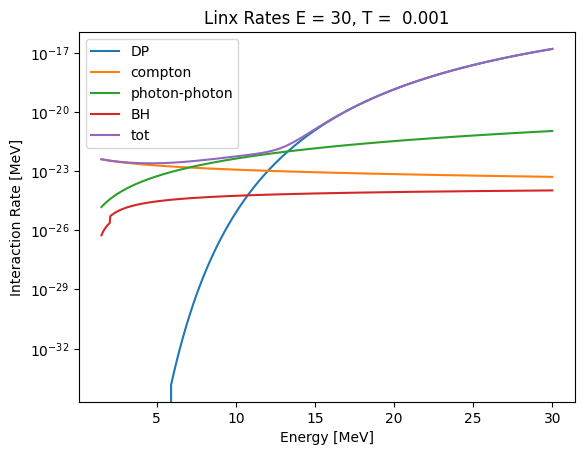

In [14]:
plt.plot(E_grid, L_DP_rate, label = "DP")
plt.plot(E_grid, L_C_rate, label = "compton")
plt.plot(E_grid, L_pp_rate, label = "photon-photon")
plt.plot(E_grid, L_BH_rate, label = "BH")
plt.plot(E_grid, R_linx0[0, :], label = 'tot')
plt.yscale('log')
plt.title(f'Linx Rates E = 30, T = {T_grid[4]: .3f}')
plt.xlabel('Energy [MeV]')
plt.ylabel('Interaction Rate [MeV]')
plt.legend()

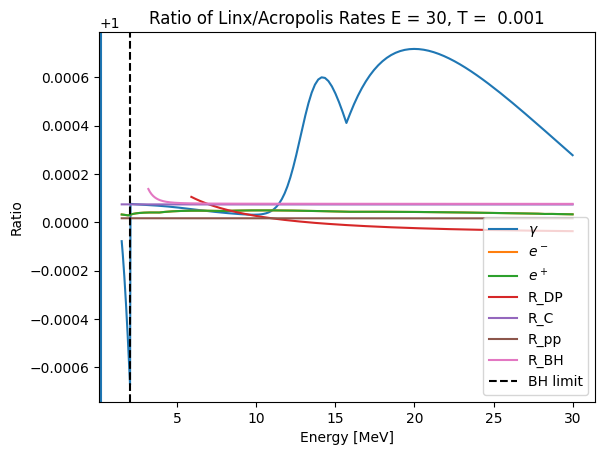

In [15]:
plt.plot(E_grid, R_linx0[0, :]/R_acro0[0, :], label = r"$\gamma$")
plt.plot(E_grid, R_linx0[1, :]/R_acro0[1, :], label = r"$e^-$")
plt.plot(E_grid, R_linx0[2, :]/R_acro0[2, :], label = r"$e^+$")
plt.plot(E_grid, L_DP_rate/a_DP_rate, label = 'R_DP')
plt.plot(E_grid, L_C_rate/a_C_rate, label = 'R_C')
plt.plot(E_grid, L_pp_rate/a_pp_rate, label = 'R_pp')
plt.plot(E_grid[50:], L_BH_rate[50:]/a_BH_rate[50:], label = 'R_BH')
plt.axvline(4*me, label = "BH limit", color = "k", linestyle = "--")
#plt.plot(E_grid, jax.vmap(InjSpec.dphoton_pair_prod_rate, in_axes=(0, None))(E_grid, T_grid[4]), label = r"$DP$")
plt.axvline(Ephb_T_max*T_grid[4]*4*me**2)
plt.title(f'Ratio of Linx/Acropolis Rates E = 30, T = {T_grid[4]: .3f}')
plt.xlabel('Energy [MeV]')
plt.ylabel('Ratio')
plt.legend()

In [16]:
f1 = jax.vmap(InjSpec.rate_x, in_axes=(None, 0, None))
f2 = jax.vmap(f1, in_axes=(0, None, None))
R_linx = f2(X_grid, E_grid, T_grid[7])

R_acro = jnp.array([[spec._rate_x(float(X), float(E), float(T_grid[7])) for E in E_grid] for X in X_grid])

In [17]:
a_DP_rate7 = jnp.array([photon._rate_pair_creation_ae(float(E), float(T_grid[7])) for E in E_grid])
L_DP_rate7 = jax.vmap(InjSpec.dphoton_pair_prod_rate, in_axes=(0, None))(E_grid, T_grid[7])
a_C_rate7 = jnp.array([photon._rate_compton(float(E), float(T_grid[7])) for E in E_grid])
L_C_rate7 = jax.vmap(InjSpec.compton_scattering_rate, in_axes=(0, None))(E_grid, T_grid[7])
a_pp_rate7 = jnp.array([photon._rate_photon_photon(float(E), float(T_grid[7])) for E in E_grid])
L_pp_rate7 = jax.vmap(InjSpec.photon_photon_scattering_rate, in_axes=(0, None))(E_grid, T_grid[7])
a_BH_rate7 = jnp.array([photon._rate_bethe_heitler(float(E), float(T_grid[7])) for E in E_grid])
L_BH_rate7 = jax.vmap(InjSpec.bethe_heitler_pair_prod_rate, in_axes=(0, None))(E_grid, T_grid[7])


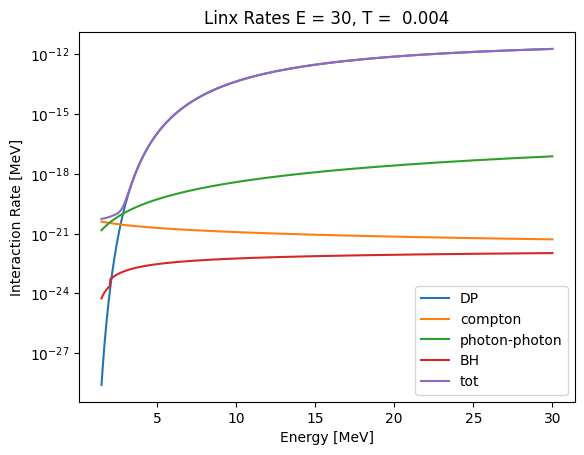

In [18]:
plt.plot(E_grid, L_DP_rate7, label = "DP")
plt.plot(E_grid, L_C_rate7, label = "compton")
plt.plot(E_grid, L_pp_rate7, label = "photon-photon")
plt.plot(E_grid, L_BH_rate7, label = "BH")
plt.plot(E_grid, R_linx[0, :], label = 'tot')
plt.yscale('log')
plt.title(f'Linx Rates E = 30, T = {T_grid[7]: .3f}')
plt.xlabel('Energy [MeV]')
plt.ylabel('Interaction Rate [MeV]')
plt.legend()

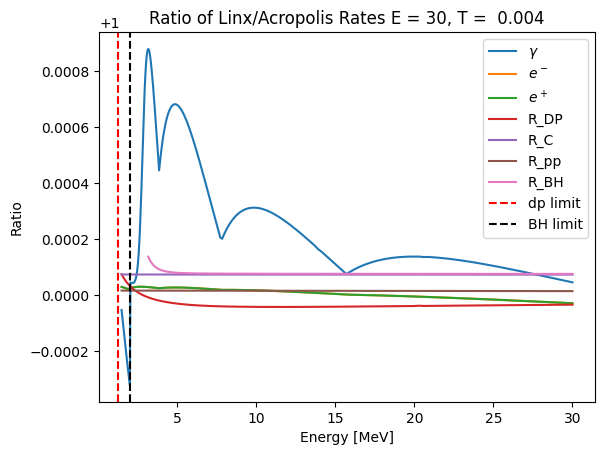

In [19]:
plt.plot(E_grid, R_linx[0, :]/R_acro[0, :], label = r"$\gamma$")
plt.plot(E_grid, R_linx[1, :]/R_acro[1, :], label = r"$e^-$")
plt.plot(E_grid, R_linx[2, :]/R_acro[2, :], label = r"$e^+$")
plt.plot(E_grid, L_DP_rate7/a_DP_rate7, label = 'R_DP')
plt.plot(E_grid, L_C_rate7/a_C_rate7,  label = 'R_C')
plt.plot(E_grid, L_pp_rate7/a_pp_rate7, label = 'R_pp')
plt.plot(E_grid[50:], L_BH_rate7[50:]/a_BH_rate7[50:], label = 'R_BH')
plt.axvline((me**2)/(50*T_grid[7]), label = "dp limit", color = "r", linestyle = "--")
plt.axvline(4*me, label = "BH limit", color = "k", linestyle = "--")
plt.title(f'Ratio of Linx/Acropolis Rates E = 30, T = {T_grid[7]: .3f}')
plt.xlabel('Energy [MeV]')
plt.ylabel('Ratio')
plt.legend()

## Sources

In [20]:
T_grid_large = jnp.logspace(jnp.log10(Tmin), jnp.log10(Tmax), 200)

In [21]:
L_S0_4 = mod.get_source_0()[1](T_grid_large)
A_S0_4 = jnp.array([Yf.get_source_terms()[0][1](T) for T in T_grid_large])

(0.98, 1.02)

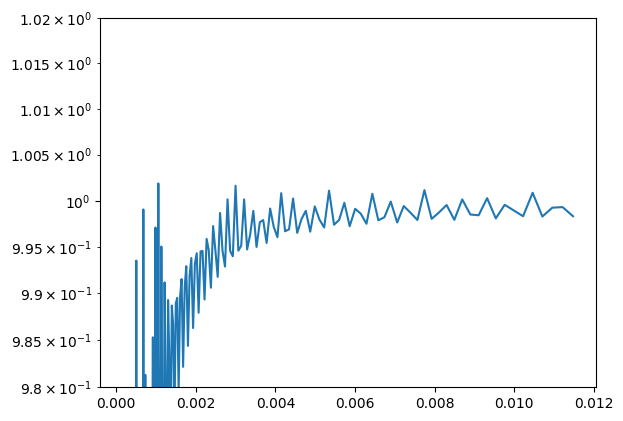

In [22]:
plt.plot(T_grid_large, L_S0_4/A_S0_4)
plt.yscale('log')
plt.ylim(1-0.02, 1+0.02)

In [23]:
L_N_4 = mod.number_density(T_grid_large)
A_N_4 = jnp.array([Yf._number_density(T) for T in T_grid_large])

Text(0, 0.5, 'Ratio')

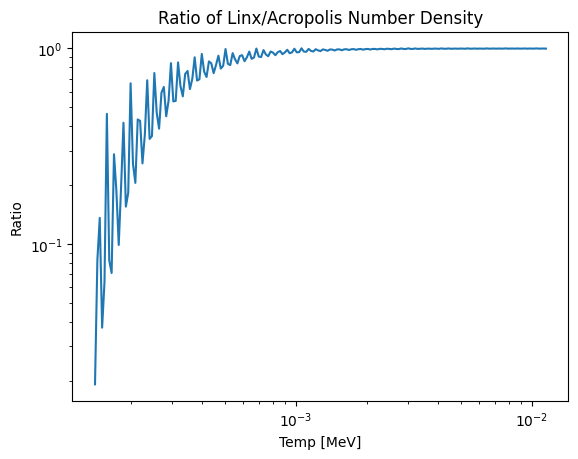

In [24]:
plt.plot(T_grid_large[4:], L_N_4[4:]/A_N_4[4:], label = "Linx")
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1-0.03, 1+0.01)
plt.title(f'Ratio of Linx/Acropolis Number Density')
plt.xlabel('Temp [MeV]')
plt.ylabel('Ratio')

In [224]:
h1 = jax.vmap(mod.S_photon_cont, in_axes=(0, None))
#L_SC_4 = jax.vmap(h1, in_axes=(None, 0))(E_grid, T_grid_large)
L_SC_4 = h1(E_grid, 0.001)
A_LC_4 = jnp.array(jnp.array([Yf._source_photon_c(E, 0.001) for E in E_grid]))

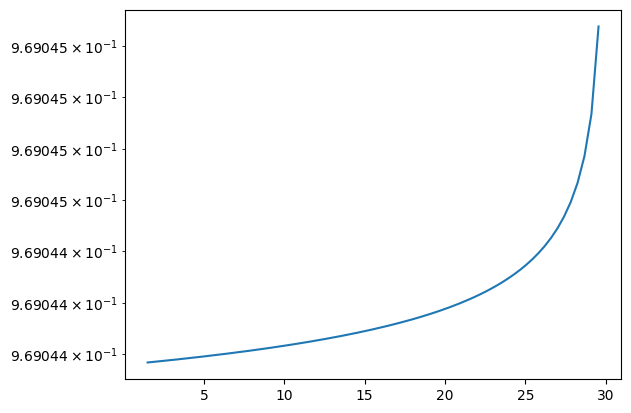

In [226]:
plt.plot(E_grid, L_SC_4/A_LC_4)
plt.yscale('log')

In [239]:
L_a_4 = mod.get_scale_factor(mod.inject_temp)/mod.get_scale_factor(T_grid_large)
A_a_4 = jnp.array([Yf._sII.scale_factor(Yf._sT0)/Yf._sII.scale_factor(T) for T in T_grid_large])

Text(0, 0.5, 'Ratio')

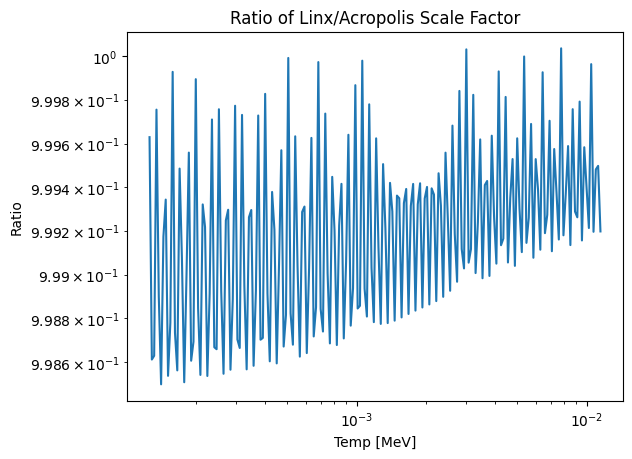

In [241]:
plt.plot(T_grid_large[4:], L_a_4[4:]/A_a_4[4:], label = "Linx")
plt.yscale('log')
plt.xscale('log')
plt.title(f'Ratio of Linx/Acropolis Scale Factor')
plt.xlabel('Temp [MeV]')
plt.ylabel('Ratio')

## Spectrum

In [ ]:
acro0 = spec.get_spectrum(30, Yf._sS0, Yf._sSc, float(T_grid[4]), True)
linx0 = InjSpec.get_spectrum(30, mod.get_source_0(), mod.get_source_cont(), T_grid[4])

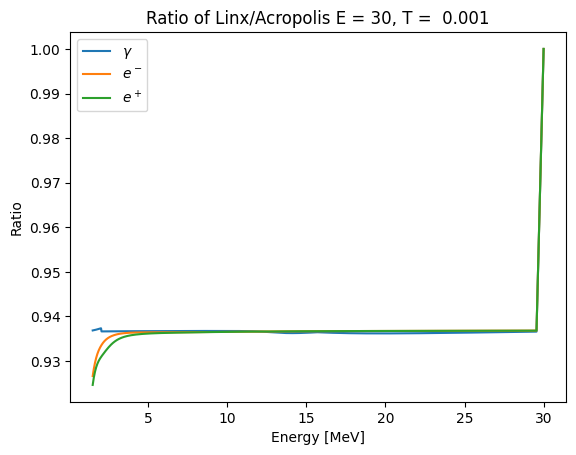

In [48]:
plt.plot(acro0[0], linx0[1]/acro0[1], label=r'$\gamma$')
plt.plot(acro0[0], linx0[2]/acro0[2], label=r'$e^-$')
plt.plot(acro0[0], linx0[3]/acro0[3], label=r'$e^+$')
plt.title(f'Ratio of Linx/Acropolis E = 30, T = {T_grid[4]: .3f}')
plt.xlabel('Energy [MeV]')
plt.ylabel('Ratio')
plt.legend()


In [49]:
acro8 = spec.get_spectrum(30, Yf._sS0, Yf._sSc, float(T_grid[8]), True)
linx8 = InjSpec.get_spectrum(30, mod.get_source_0(), mod.get_source_cont(), T_grid[8])

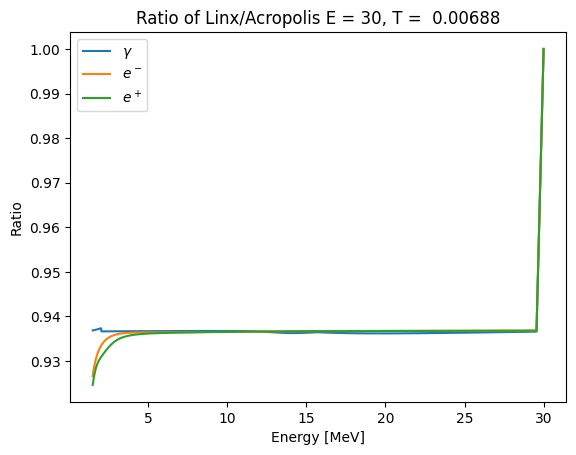

In [50]:
plt.plot(acro0[0], linx0[1]/acro0[1], label=r'$\gamma$')
plt.plot(acro0[0], linx0[2]/acro0[2], label=r'$e^-$')
plt.plot(acro0[0], linx0[3]/acro0[3], label=r'$e^+$')
plt.title(f'Ratio of Linx/Acropolis E = 30, T = {T_grid[8]: .5f}')
plt.xlabel('Energy [MeV]')
plt.ylabel('Ratio')
plt.legend()
